## Introduction
In this notebook we will create and train the classifier on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))   # keep 224x224 and crop only areas without information scale=(min, max)

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])




Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

In [4]:
train_dataset = torchvision.datasets.DatasetFolder(
    r"C:\Users\keoha\Desktop\Technik\ML\Udemy\Deep Learning Pytorch Medical Imaging\AI-IN-MEDICAL-MATERIALS\04-Pneumonia-Classification\rsna-pneumonia-detection-challenge\Processed\train",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    r"C:\Users\keoha\Desktop\Technik\ML\Udemy\Deep Learning Pytorch Medical Imaging\AI-IN-MEDICAL-MATERIALS\04-Pneumonia-Classification\rsna-pneumonia-detection-challenge\Processed\val",
    loader=load_file, extensions="npy", transform=val_transforms)


Let's inspect some augmented train images

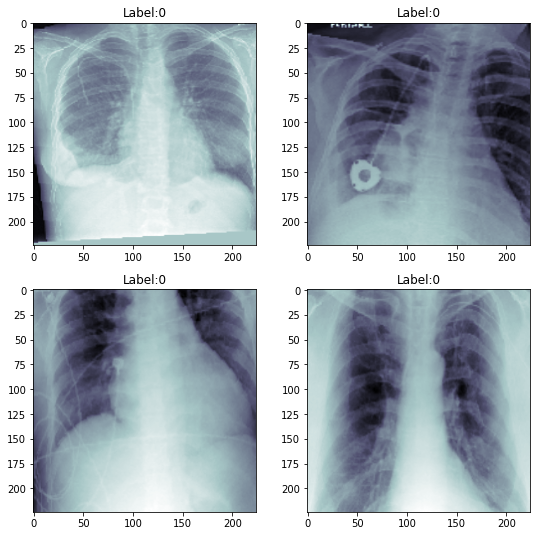

In [5]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [6]:
batch_size = 64#TODO: represents how many samples per batch to load
num_workers = 4# TODO: represents how many subprocesses to use for loading data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True) # shuffling training data is important, shuffling the labels and correspinding images
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False) # do not shuffle validation set in order to get a deterministic order of validation

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss: Assigns higher loss to a prediction, if model errornously predicts the negative class. Using a weightes loss of 3, because there are apporx. 3-times more "0"-class images than "1"-class images.
* Oversampling: Show network as many samples from class "1" as from class "0"
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [7]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

## Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.


In [8]:
# get a visualization of the model and its layers

torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
## create model class: Stores training, validation, logging and prediction

class PneumoniaModel(pl.LightningModule): # inherit from pl.lightning module
    def __init__(self, weight=1):
        super().__init__() # has something to do with inheritance (Vererbung)
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight])) # use weighted version, expects a tensor
        
        # define some metrics, simple accuracy computation 
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data) # compute output of ResNet18 and return raw data
        return pred
    
    def training_step(self, batch, batch_idx): # handled by pl.lightning, never called "by hand"
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape, remove second dimension when calling forward (self(xray))
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int())) # convert prediction into a probability with sigmoid
        return loss # simply return loss, so pl.light5ning can optimize the model on it
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        # Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [10]:
model = PneumoniaModel()  # Instanciate the model

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [11]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max') # sort by highest, not lowest accuracy

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [12]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

gpus = 0 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
trainer.fit(model, train_loader, val_loader)




  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluation

Let's evaluate our model!
At first, we load the latest checkpoint and send the model to the GPU, if possible.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("weights/weights_1.ckpt")
model.eval()
model.to(device);

Compute prediction on the complete validation set and store predictions and labels

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


Compute metrics:
We can see that the overall result is already decent with our simple model.<br />
However, we suffer from a large amount of False Negatives due to the data imbalance.<br />
This is of particular importance in to avoid in medical imaging as missing findings might be fatal.<br />
Feel free to try what happens if you increase or decrease the weight in the loss.

An alternative to retraining with a weighted loss is to reduce the classification threshold from 0.5 to e.g 0.25. It produces way less false negatives but increases the number of False positives. <br />
This is called the precision-recall tradeoff

In [ ]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


Congratulation! You made it to the end of the notebook and to the end of the classification lecture.